**The objective of this challenge is to forecast the number of turtles caught per week per capture site. This will help Local Ocean plan their staff schedules and budget.**

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 200, "display.max_rows", 200)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [47]:
turtle = pd.read_csv("train.csv")
varDesc = pd.read_csv("variable_definitions.csv", engine="python")
submissionSample = pd.read_csv("Sample_sub.csv")
turtle.shape

(18062, 21)

In [48]:
turtle.head()

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02


In [50]:
turtle["ForagingGround"] = turtle["ForagingGround"].apply(lambda x: str(x).lower())
turtle["CaptureMethod"] = turtle["CaptureMethod"].apply(lambda x: str(x).lower())

In [51]:
turtle["Date_TimeCaught"] = pd.to_datetime(turtle["Date_TimeCaught"])
turtle["Date_TimeCaught"].dtype

dtype('<M8[ns]')

In [52]:
turtle["Date_TimeCaughtYear"] = turtle["Date_TimeCaught"].apply(lambda x: x.strftime("%Y"))
turtle["Date_TimeCaughtWeek"] = turtle["Date_TimeCaught"].apply(lambda x: x.strftime("%W"))

turtle[["Date_TimeCaughtYear", "Date_TimeCaughtWeek"]].head()

,Date_TimeCaughtYear,Date_TimeCaughtWeek
0,2000,51
1,2001,43
2,2001,44
3,2002,10
4,2002,31


In [53]:
turtle.head()

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease,Date_TimeCaughtYear,Date_TimeCaughtWeek
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,ocean,net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00,2000,51
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,ocean,net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01,2001,43
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,ocean,net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01,2001,44
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,ocean,net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02,2002,10
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,ocean,beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02,2002,31


## Exploratory Data Analysis

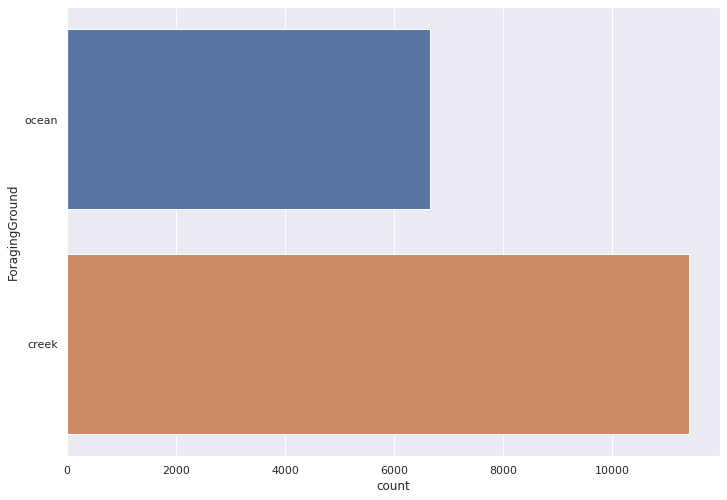

In [54]:
sns.countplot(y="ForagingGround", data=turtle)

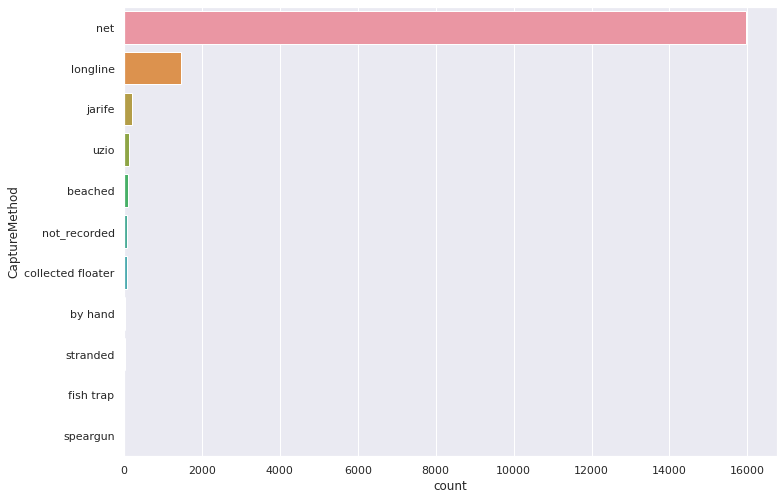

In [55]:
sns.countplot(y="CaptureMethod", data=turtle, order=turtle["CaptureMethod"].value_counts().index)

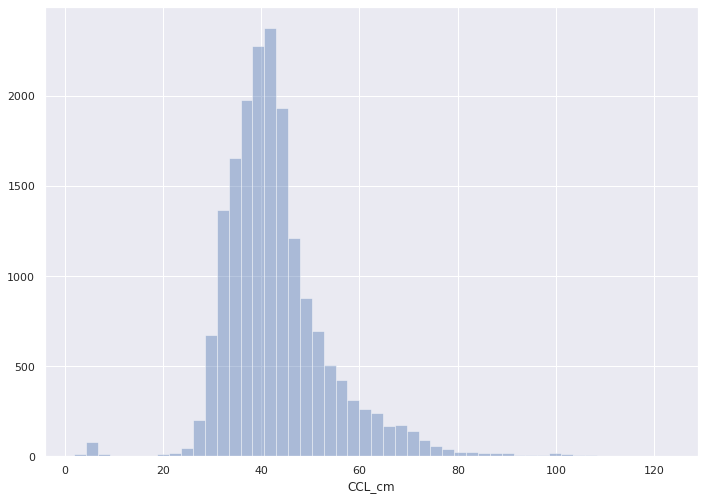

In [119]:
sns.distplot(turtle["CCL_cm"], kde=False)

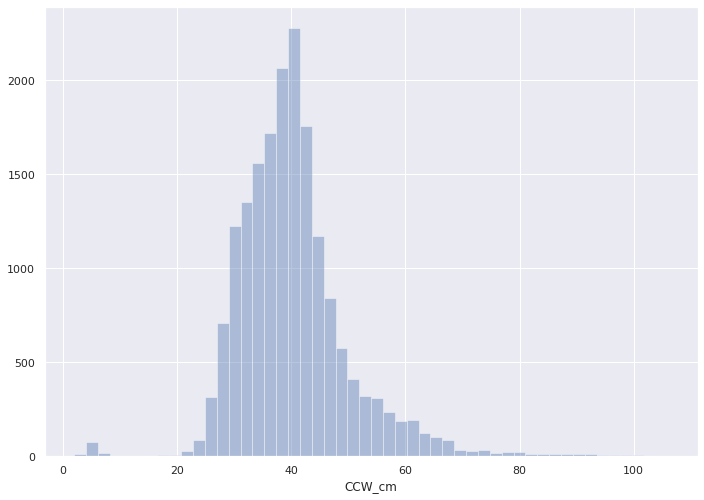

In [120]:
sns.distplot(turtle["CCW_cm"], kde=False)

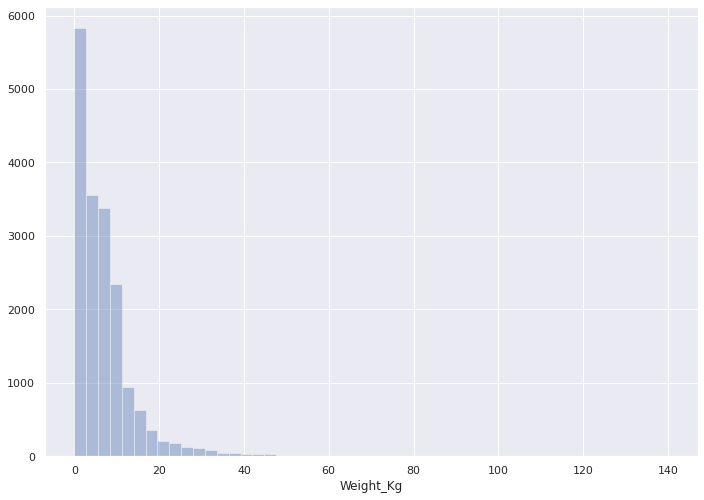

In [126]:
sns.distplot(turtle["Weight_Kg"], kde=False)

In [ ]:
turtle.isnull().sum()

In [58]:
turtle.fillna(value={"Weight_Kg": 0, "Sex": "Unknown", "Lost_Tags": "None", "T_Number": "None"}, inplace=True)
turtle.replace({"Sex": {"Not_Recorded": "Unknown"}}, inplace=True)

In [60]:
turtle["Sex"].unique()

array(['Unknown', 'Female', 'Male'], dtype=object)

In [61]:
turtle["Weight_Kg"].head(2)

0    0.0
1    0.0
Name: Weight_Kg, dtype: float64

In [62]:
submissionSample.head(2)

,ID,Capture_Number
0,CaptureSite_0_201901,7
1,CaptureSite_0_201902,1


In [63]:
turtle["Target"] = turtle["CaptureSite"] + "_" + turtle["Date_TimeCaughtYear"] + turtle["Date_TimeCaughtWeek"]
turtle[["Target", "CaptureSite"]].head()

,Target,CaptureSite
0,CaptureSite_0_200051,CaptureSite_0
1,CaptureSite_0_200143,CaptureSite_0
2,CaptureSite_0_200144,CaptureSite_0
3,CaptureSite_0_200210,CaptureSite_0
4,CaptureSite_0_200231,CaptureSite_0


In [104]:
trainTurtle = turtle.groupby(["Target", "CaptureSite", "Date_TimeCaughtYear"]).agg({"Rescue_ID": "count", "Researcher": "nunique", 
                                                             "LandingSite": "nunique", 
                                                             "ForagingGround": "nunique", 
                                                             "CaptureMethod": "nunique", "Fisher": "nunique", 
                                                             "Species": "nunique", "Lost_Tags": "nunique", 
                                                             "CCL_cm": "mean", "CCW_cm": "mean", 
                                                             "Weight_Kg": "mean", "Sex": "nunique", 
                                                             "Status": "nunique", 
                                                             "ReleaseSite": "nunique"}).reset_index()
trainTurtle.shape

(7971, 17)

In [105]:
trainTurtle.rename(columns={"Target": "ID", "Rescue_ID": "Capture_Number"}, inplace=True)

In [109]:
trainTurtle["Date_TimeCaughtYear"] = pd.to_numeric(trainTurtle["Date_TimeCaughtYear"])

In [106]:
trainTurtle.head()

,ID,CaptureSite,Date_TimeCaughtYear,Capture_Number,Researcher,LandingSite,ForagingGround,CaptureMethod,Fisher,Species,Lost_Tags,CCL_cm,CCW_cm,Weight_Kg,Sex,Status,ReleaseSite
0,CaptureSite_0_200051,CaptureSite_0,2000,1,1,1,1,1,1,1,1,64.70,62.60,0.0,1,1,1
1,CaptureSite_0_200143,CaptureSite_0,2001,1,1,1,1,1,1,1,1,35.85,31.35,0.0,1,1,1
2,CaptureSite_0_200144,CaptureSite_0,2001,1,1,1,1,1,1,1,1,51.80,49.20,0.0,1,1,1
3,CaptureSite_0_200210,CaptureSite_0,2002,1,1,1,1,1,1,1,1,60.50,59.00,0.0,1,1,1
4,CaptureSite_0_200231,CaptureSite_0,2002,2,1,1,1,2,1,1,1,33.95,31.85,0.0,1,1,2


In [124]:
trainTurtle.sort_values(by=["Capture_Number"], ascending=False).head()

,ID,CaptureSite,Date_TimeCaughtYear,Capture_Number,Researcher,LandingSite,ForagingGround,CaptureMethod,Fisher,Species,Lost_Tags,CCL_cm,CCW_cm,Weight_Kg,Sex,Status,ReleaseSite
5166,CaptureSite_25_200847,CaptureSite_25,2008,35,1,1,1,1,7,1,3,48.831429,45.380000,0.000000,1,1,1
5170,CaptureSite_25_200851,CaptureSite_25,2008,28,1,1,1,1,3,1,2,49.278571,46.089286,0.000000,1,0,2
5916,CaptureSite_27_201307,CaptureSite_27,2013,23,4,1,1,1,4,1,3,58.982609,53.278261,31.032609,2,2,4
5167,CaptureSite_25_200848,CaptureSite_25,2008,22,1,1,1,2,5,1,5,48.827273,45.327273,0.000000,1,0,1
5175,CaptureSite_25_200903,CaptureSite_25,2009,21,1,1,1,1,2,1,3,50.838095,47.247619,0.000000,1,0,2


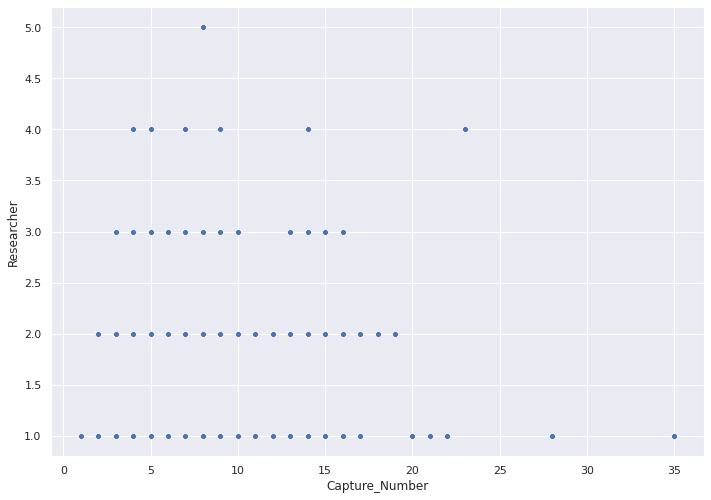

In [103]:
sns.scatterplot(x="Capture_Number", y="Researcher", data=trainTurtle)

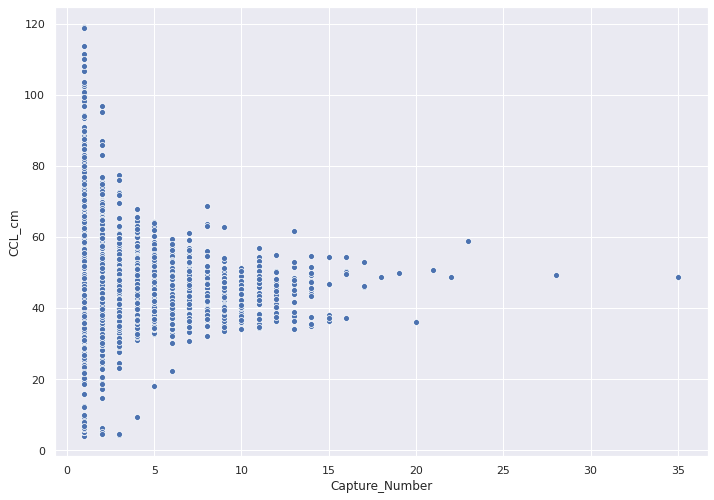

In [115]:
sns.scatterplot(x="Capture_Number", y="CCL_cm", data=trainTurtle)

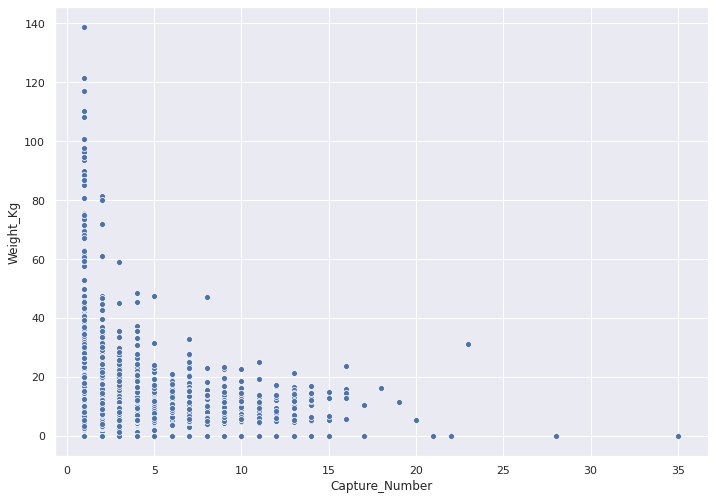

In [127]:
sns.scatterplot(x="Capture_Number", y="Weight_Kg", data=trainTurtle)

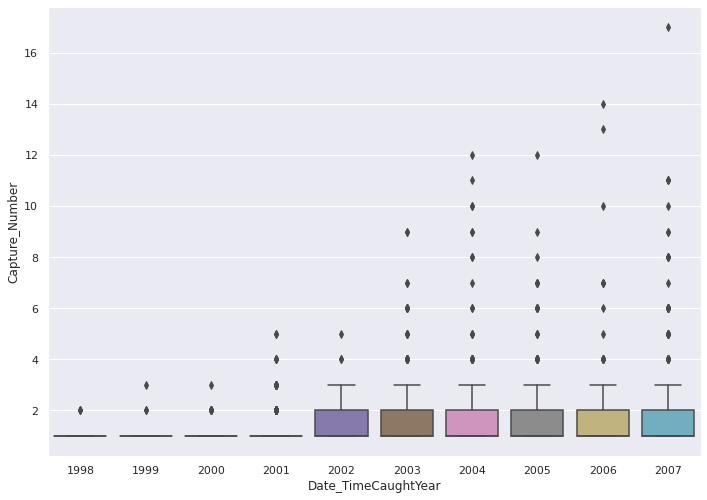

In [110]:
sns.boxplot(x="Date_TimeCaughtYear", y="Capture_Number", 
            data=trainTurtle[(trainTurtle["Date_TimeCaughtYear"] > 1997) & (trainTurtle["Date_TimeCaughtYear"] < 2008)])

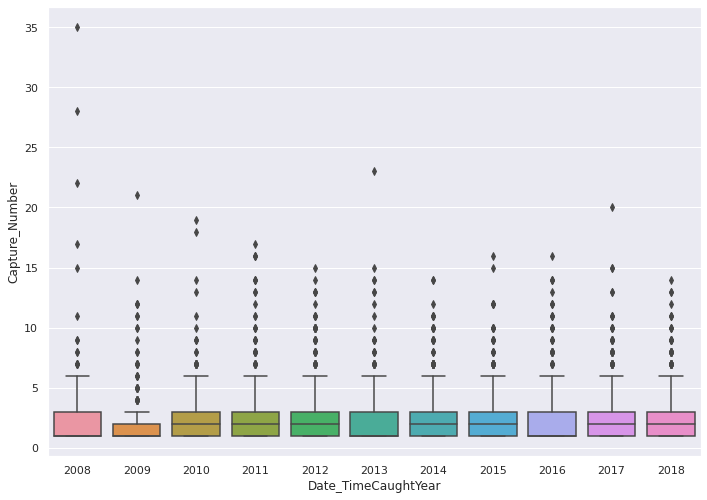

In [111]:
sns.boxplot(x="Date_TimeCaughtYear", y="Capture_Number", 
            data=trainTurtle[(trainTurtle["Date_TimeCaughtYear"] > 2007) & (trainTurtle["Date_TimeCaughtYear"] < 2019)])